In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data import get_data
from neuralNet import FeedForwardNet
from trainNet import train
from validation import validate_and_plot
from terminalNet import *
import numpy as np
import crocoddyl
import torch
from crocoddyl_vs_crocddyl_terminal_model import *
from utils import *

In [3]:
costnet = torch.load("Network.pth")
statenet = torch.load("StateNet.pth")
controlnet = torch.load("ControlNet.pth")

In [14]:
xtest = circular()

iters         = []
cost          = []
xs            = []
let = 0
for xyz in xtest:

    model = crocoddyl.ActionModelUnicycle()
    costTerminal = UnicycleTerminal(costnet)


    # Lets get the warmstart
    statenet.eval()
    xtest = torch.tensor(xyz, dtype = torch.float32)
    with torch.no_grad():
        pred = statenet(xtest)
        
        
    controlnet.eval()
    with torch.no_grad():
        pred_c = controlnet(xtest)
        

    state_ = pred.numpy().reshape(31, 3).tolist()
    state = []
    for i in state_:
        state.append(np.array(i))
        
        
    cstate_ = pred_c.numpy().reshape(30, 2).tolist()
    cstate = []
    for i in cstate_:
        cstate.append(np.array(i))
        
    


    T = 30
    model.costWeights = np.matrix([1,1]).T

    problem = crocoddyl.ShootingProblem(m2a(xyz).T, [ model ] * T, costTerminal)
    ddp = crocoddyl.SolverDDP(problem)
    ddp.solve(state, cstate, 1000)    
    if ddp.iter < 100:
        let += 1
        cost.append(ddp.cost)
        iters.append(ddp.iter)

        xs_ = np.array(ddp.xs)
        ddp_xs = xs_[:,0:2]
        xs.append(ddp_xs)
    

In [15]:
def plot_trajectories(cost, trajectories, name = "Cost"):
    """
    
    @params:
        cost           = list of keys for cmap
        trajectories   = list of corresponding trajectories
        name           = str, to distinguish between cost and iterations
        
    @ returns plot of trajectories colored according to keys.    
    
    """

    import matplotlib as mpl
    import matplotlib.pyplot as plt
    mpl.rcParams['figure.dpi'] = 80
    fig = plt.figure(figsize=(8, 6))

    norm = mpl.colors.Normalize(vmin=float(min(cost)), vmax=float(max(cost)))
    cmap = mpl.cm.ScalarMappable(norm = norm, cmap=mpl.cm.plasma)
    cmap.set_array([])


    for key, trajectory in zip(cost, trajectories):
        plt.scatter(trajectory[:, 0], trajectory[:, 1], 
                    marker = '',
                    zorder=2, 
                    s=50,
                    linewidths=0.2,
                    alpha=.8, 
                    cmap = cmap )
        plt.plot(trajectory[:, 0], trajectory[:, 1], c=cmap.to_rgba(key))

    plt.xlabel("X Coordinates", fontsize = 20)
    plt.ylabel("Y Coordinates", fontsize = 20)
    plt.colorbar(cmap).set_label(name, labelpad=2, size=15)
    plt.show()

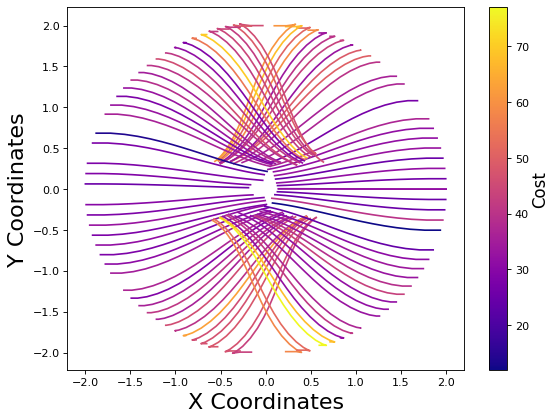

In [16]:
plot_trajectories(iters, xs)

In [17]:
let

87